In [2]:
from diffusers import StableDiffusionPipeline, AutoencoderKL, DDPMScheduler
import torch
import torch.nn.functional as F

import os

from PIL import Image

from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 1

In [5]:
%aimport zizi_pipeline
%aimport zizi_vae_pipeline

In [6]:
from zizi_pipeline import TrainingConfig, get_dataloader, get_adamw, get_lr_scheduler, get_ddpm
from zizi_vae_pipeline import get_vae_unet, ZiziVaePipeline

In [7]:
vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="vae")
vae.config.sample_size = 512

In [8]:
config = TrainingConfig("data/pink-me/", "output/pink-vae-256", image_size=512)

In [9]:
train_dataloader = get_dataloader(config)
dataset = train_dataloader.dataset

In [10]:
latent = vae.encode(dataset[0]['images'].unsqueeze(0))

In [11]:
latent_vector = latent.latent_dist.sample() * vae.config.scaling_factor

In [12]:
model = get_vae_unet(config)

In [13]:
sample_pose = dataset[0]["poses"].unsqueeze(0)

In [14]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(latent_vector.shape)
timesteps = torch.LongTensor([50])
noisy_latents = noise_scheduler.add_noise(latent_vector, noise, timesteps)

In [15]:
optimizer = get_adamw(config, model)
lr_schedule = get_lr_scheduler(config, optimizer, train_dataloader)

torch.Size([1, 4, 64, 64])


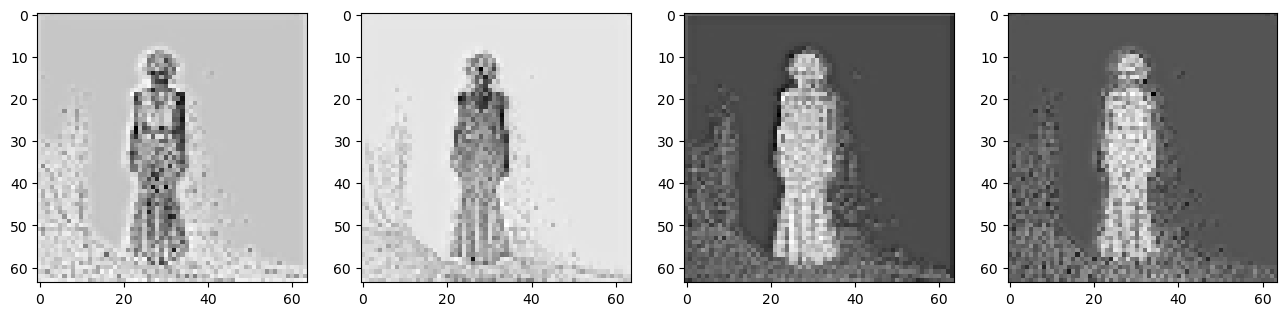

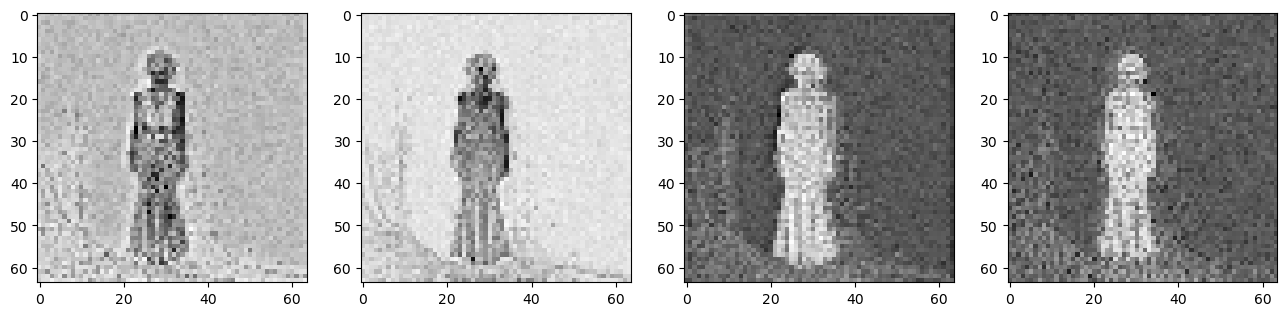

In [16]:
def show_latents(l):
    fig, axs = plt.subplots(1, 4, figsize=(16,4))
    for c in range(4):
        axs[c].imshow(l[0][c].cpu().detach(), cmap='Greys')

print(latent_vector.shape)
show_latents(latent_vector)
show_latents(noisy_latents)

In [17]:
noise_pred = model(noisy_latents, timesteps, sample_pose.view((1, 1, 75))).sample

In [18]:
p = ZiziVaePipeline(model, noise_scheduler, vae).to("mps")

  0%|          | 0/10 [00:00<?, ?it/s]

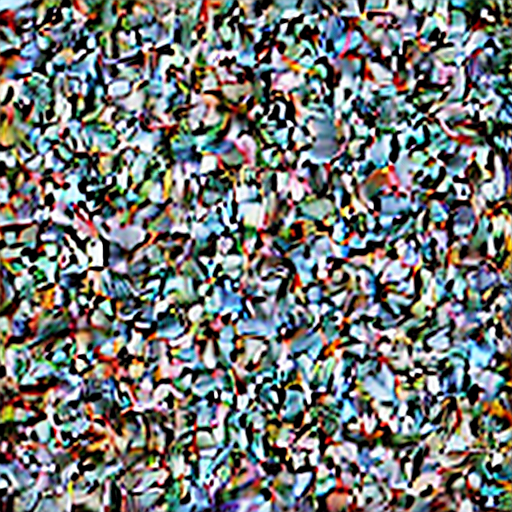

In [19]:
p(sample_pose.to("mps"), num_inference_steps=10).images[0]

In [20]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

In [21]:
def evaluate(
    config: TrainingConfig, epoch, pipeline, condition: torch.FloatTensor
):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        condition,
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        num_inference_steps=50,
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=2, cols=2)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [22]:
def train_loop(config, vae):
    from accelerate import Accelerator
    # Initialize accelerator
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    train_dataloader = get_dataloader(config)

    vae = vae.to(accelerator.device)
    model = get_vae_unet(config)
    noise_scheduler = get_ddpm()
    optimizer = get_adamw(config, model)
    lr_scheduler = get_lr_scheduler(config, optimizer, train_dataloader)

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(
            total=len(train_dataloader), disable=not accelerator.is_local_main_process
        )
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            print(clean_images.shape)

            with torch.no_grad():
                latent = vae.encode(clean_images)

            latent_vector = latent.latent_dist.sample() * vae.config.scaling_factor
            
            # Sample noise to add to the latents
            noise = torch.randn(latent_vector.shape).to(accelerator.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each latent
            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (bs,),
                device=accelerator.device,
            ).long()

            # Add noise to the clean latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latent_vector, noise, timesteps)

            poses = batch["poses"].reshape((bs, 1, 75))

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_latents, timesteps, poses, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = ZiziVaePipeline(
                vae=vae,
                unet_cond=accelerator.unwrap_model(model),
                scheduler=noise_scheduler,
            ).to(accelerator.device)

            if (
                epoch + 1
            ) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(
                    config,
                    epoch,
                    pipeline,
                    train_dataloader.dataset[0]["poses"]
                    .unsqueeze(0)
                    .to(accelerator.device),
                )

            if (
                epoch + 1
            ) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(f"{config.output_dir}/checkpoint-{str(epoch)}")

In [23]:
from accelerate import notebook_launcher

notebook_launcher(train_loop, (config, vae), num_processes=1)

Launching training on MPS.


/opt/homebrew/Caskroom/mambaforge/base/envs/jupyter/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/opt/homebrew/Caskroom/mambaforge/base/envs/jupyter/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


  0%|          | 0/894 [00:00<?, ?it/s]

torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])


KeyboardInterrupt: 